**Introduction**

About Dataset

Data taken from: https://www.kaggle.com/snap/amazon-fine-food-reviews

Dataset consists of reviews of fine foods from Amazon.It consist of 568454 reviews taken between the span of 13 years. 

Data includes:


*   568,454 reviews
*   256,059 users



*   74,248 unique products
*  260 users with > 50 reviews







**Exploratory visualization of Amazon fine food**

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [16]:
con=sqlite3.connect("/content/drive/My Drive/Applied AI-Data/database.sqlite")
filtered_Data=pd.read_sql_query("""Select * From Reviews Where Score !=3 """,con)
filtered_Data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [27]:
print("Total number of reviews", len(filtered_Data))

Total number of reviews 525814


In [28]:
print("Attributes given in dataset" ,list(filtered_Data.columns))

Attributes given in dataset ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


In [39]:
print("total number of unique users:", len(filtered_Data['UserId'].unique()))

total number of unique users 243414


In [43]:
ax=filtered_Data.Score.value_counts(sort=True)
print(ax)
type(ax)

5    363122
4     80655
1     52268
2     29769
Name: Score, dtype: int64


pandas.core.series.Series

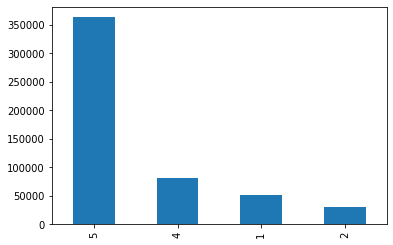

In [56]:
ax=filtered_Data.Score.value_counts().plot(kind='bar')
